In [1]:
import os
from rdkit import Chem
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from utils import get_experiments

In [2]:
d = "slga_hyper2"
e = get_experiments(d)
e.Nits = e.Nits.astype(int)
e = e.sort_values("Nits")
palette = sns.color_palette("Spectral", 4)[::-1]

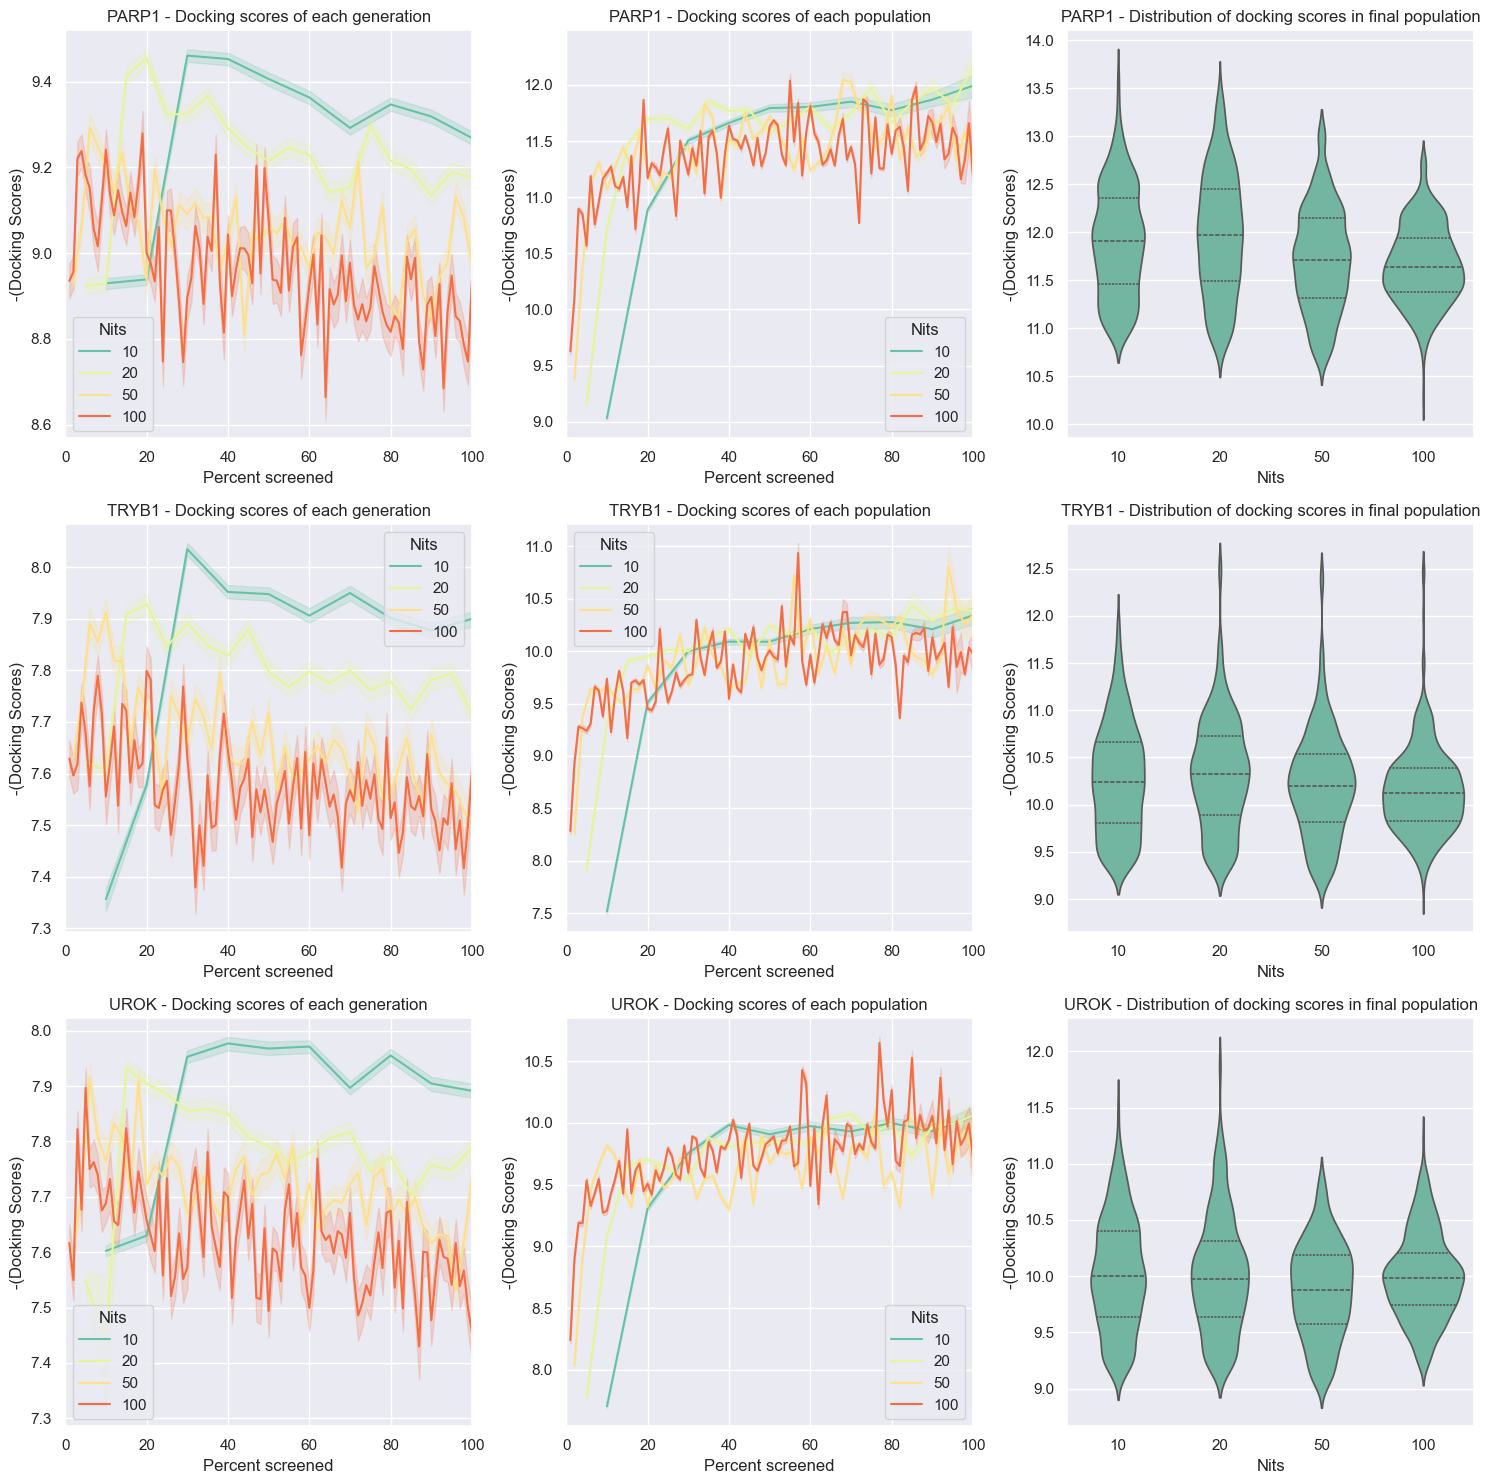

In [3]:
sns.set_theme()
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for k, (t, subset) in enumerate(e.groupby("Target")):
    subset.Pc = subset.Pc.astype(float)
    subset = subset.sort_values(["Nits"])
    # Generation docking scores
    combined = None
    ax = axes[k,0]
    for _, row in subset.iterrows():
        df = pd.concat([pd.read_parquet(f"{row.path}/gen_{n}.parquet") for n in range(1,row.Nits+1)])
        df["Nits"] = row.Nits
        combined = pd.concat([combined, df])
    combined["Percent screened"] = combined.apply(lambda x: int(x.generation*(200000/x.Nits)/2000), axis=1)
    sns.lineplot(combined, x="Percent screened", y="scores", hue="Nits", palette=palette, ax=ax)
    ax.set_ylabel("-(Docking Scores)")
    ax.set_xlim(0,100)
    ax.set_title(f"{t} - Docking scores of each generation")
    ax = axes[k,1]

    # Population docking scores
    combined = None
    for _, row in subset.iterrows():
        df = pd.concat([pd.read_parquet(f"{row.path}/pop_{n}.parquet") for n in range(1,row.Nits+1)])
        df["Nits"] = row.Nits
        combined = pd.concat([combined, df])
    combined["Percent screened"] = combined.apply(lambda x: int(x.generation*(200000/x.Nits)/2000), axis=1)
    sns.lineplot(combined, x="Percent screened", y="scores", hue="Nits", palette=palette, ax=ax)
    ax.set_ylabel("-(Docking Scores)")
    ax.set_xlim(0,100)
    ax.set_title(f"{t} - Docking scores of each population")

    # Violin plot final population
    ax = axes[k,2]
    combined = None
    for _, row in subset.iterrows():
        df = pd.read_parquet(f"{row.path}/pop_{row.Nits}.parquet")
        df["Nits"] = row.Nits
        combined = pd.concat([combined, df])
    sns.violinplot(combined, y="scores", x="Nits", inner="quart", ax=ax, color=palette[0])
    ax.set_title(f"{t} - Distribution of docking scores in final population")
    ax.set_ylabel("-(Docking Scores)")

plt.tight_layout()
plt.savefig("../figures/slga_its.pdf")